# Policy Optimization with more efficient samples utilization - model based control problem of RL

### Legacy repo does not work with gymnasium so some installs and hacks are needed

In [2]:
#!pip install git+https://github.com/mimoralea/gym-walk#egg=gym-walk

In [1]:
#!pip install gym_walk
#!pip install gymnasium

In [1]:
#import numpy as np
#import gymnasium as gym, gym_walk
#import gymnasium as gym
#from gym_walk.envs import WalkEnv

In [2]:
#from gymnasium.envs.registration import register

In [3]:
#register(
#    # One non-terminal states and two terminal
#    # Technically speaking, this is a bandit MDP
#    id='BanditWalk-v0',
#    entry_point='gym_walk.envs:WalkEnv',
#    # left-most and right-most states are terminal
#    kwargs={'n_states': 1, 'p_stay': 0.0, 'p_backward': 0.0},
#    max_episode_steps=100,
#    reward_threshold=1.0,
#    nondeterministic=True,
#)

In [4]:
#register(
#    # One non-terminal states and two terminal
#    # Technically speaking, this is a bandit MDP
#    id='BanditSlipperyWalk-v0',
#    entry_point='gym_walk.envs:WalkEnv',
#    # left-most and right-most states are terminal
#    kwargs={'n_states': 1, 'p_stay': 0.0, 'p_backward': 0.2},
#    max_episode_steps=100,
#    reward_threshold=1.0,
#    nondeterministic=True,
#)

In [5]:
## (Stochastic) Markov Decission Problem: MDP
## s a (p(a|s), s', r, Teminal?)
#P = {
#    0: {
#        0: [(1.0, 0, 0.0, True)],
#        1: [(1.0, 0, 0.0, True)]
#    },
#    1: {
#        0: [(0.8, 0, 0.0, True), (0.2, 2, 1.0, True)],
#        1: [(0.8, 2, 1.0, True), (0.2, 0, 0.0, True)]
#    },
#    2: {
#        0: [(1.0, 2, 0.0, True)],
#        1: [(1.0, 2, 0.0, True)]
#    }
#}

In [6]:
#env = gym.make('BanditWalk-v0')

# Environment setup

### Upon installing gym_walk lib one can actuall directly instantiate envs used in the book by using proper env parameters

In [1]:
import numpy as np
from gym_walk.envs import WalkEnv

from tqdm import tqdm
import matplotlib.pyplot as plt

from itertools import count

### Slippery walk 1D AKA two-arm stochastic bandid

In [6]:
env = WalkEnv(n_states=7, p_stay=0.33, p_backward=0.16)

In [3]:
env.P

{0: {0: [(0.5099999999999999, 0, 0.0, True),
   (0.33, 0, 0.0, True),
   (0.16, 1, 0.0, False)],
  1: [(0.5099999999999999, 1, 0.0, False),
   (0.33, 0, 0.0, True),
   (0.16, 0, 0.0, True)]},
 1: {0: [(0.5099999999999999, 0, 0.0, True),
   (0.33, 1, 0.0, False),
   (0.16, 2, 0.0, False)],
  1: [(0.5099999999999999, 2, 0.0, False),
   (0.33, 1, 0.0, False),
   (0.16, 0, 0.0, True)]},
 2: {0: [(0.5099999999999999, 1, 0.0, False),
   (0.33, 2, 0.0, False),
   (0.16, 3, 0.0, False)],
  1: [(0.5099999999999999, 3, 0.0, False),
   (0.33, 2, 0.0, False),
   (0.16, 1, 0.0, False)]},
 3: {0: [(0.5099999999999999, 2, 0.0, False),
   (0.33, 3, 0.0, False),
   (0.16, 4, 0.0, False)],
  1: [(0.5099999999999999, 4, 0.0, False),
   (0.33, 3, 0.0, False),
   (0.16, 2, 0.0, False)]},
 4: {0: [(0.5099999999999999, 3, 0.0, False),
   (0.33, 4, 0.0, False),
   (0.16, 5, 0.0, False)],
  1: [(0.5099999999999999, 5, 0.0, False),
   (0.33, 4, 0.0, False),
   (0.16, 3, 0.0, False)]},
 5: {0: [(0.50999999999999

In [4]:
env.reset()

(4, {'prob': 1.0})

In [5]:
env.step(1)

(4, 0.0, False, False, {'prob': 0.33, 'success': False})

## MC policy evaluation

In [6]:
env.action_space

Discrete(2)

In [7]:
env.action_space.n

2

In [8]:
# 10^{-3...0} every 1/10, so we get 10 points of 10 raised to linear space power in the range [-3, 0]
np.logspace(-2, 0, 10, base=10, endpoint=True)

array([0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637,
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ])

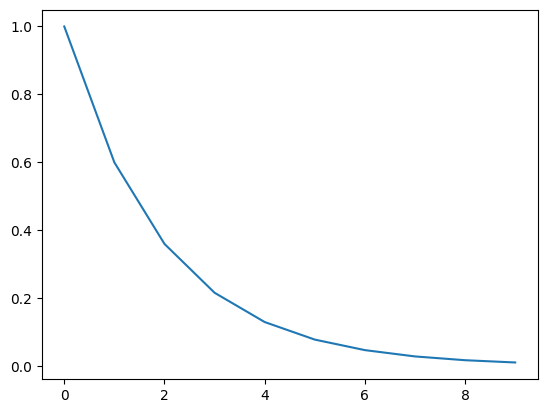

In [94]:
plt.plot(np.logspace(-2, 0, 10, base=10, endpoint=True)[::-1])

In [7]:
def decay_schedule(init_value,
                   min_value,
                   decay_ratio,
                   max_steps,
                   log_start=-2,
                   log_base=10):
    
    decay_steps = int(decay_ratio * max_steps)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min())/(values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    # padding (0, rem_steps) padds 0 elements on the left and rem_steps elements on the right, with edge value
    values = np.pad(values, (0, rem_steps), 'edge')
    
    return values

In [8]:
# Generate a single experience trajectory passing an episode up to done or max_steps limit
def generate_trajectory(select_action, Q, epsilon, env, max_steps=200):
    done, trajectory = False, []
    while not done:
        state = env.reset()[0] # There was no [0] in the Grokking RL book
        for t in count():
            # In control problem we allow for a more generic action selection
            action = select_action(state, Q, epsilon)
            # Typical step return value for walk-5:
            # (5, 0.0, False, False, {'prob': 0.5, 'success': False})
            next_state, reward, done, _ , _= env.step(action)
            experience = (state, action, reward, next_state, done)
            trajectory.append(experience)
            if done:
                break
            if t >= max_steps - 1:
                trajectory = []
                break
            state = next_state

    return np.array(trajectory, 'object')

## SARSA(\lambda) with replacing eligibility traces

In [24]:
def sarsa_lambda(env,
          gamma=1.0,
          init_alpha=0.5,
          min_alpha=0.01,
          alpha_decay_ratio=0.3,
          init_epsilon=0.5,
          min_epsilon=0.01,
          epsilon_decay_ratio=0.9,
          n_episodes=3000,
          lambda_=0.5,
          replacing_traces=True):
    nS, nA = env.observation_space.n, env.action_space.n
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)

    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)

    E = np.zeros((nS, nA), dtype=np.float64)
    
    select_action = lambda state, Q, epsilon: \
        np.argmax(Q[state]) if np.random.random() > epsilon else np.random.choice(len(Q[state]))
    
    for e in tqdm(range(n_episodes), leave=False):
        E.fill(0)
        
        state, done = env.reset()[0], False
        action = select_action(state, Q, epsilons[e])
    
        while not done:
            next_state, reward, done, _, _ = env.step(action)
            next_action = select_action(next_state, Q, epsilons[e])
            td_target = reward + gamma * Q[next_state][next_action] * (not done)
            td_error = td_target - Q[state][action]

            E[state][action] = E[state][action] + 1
            if replacing_traces: E.clip(0, 1, out=E)
                
            Q = Q + alphas[e] * td_error * E
            E = gamma * lambda_ * E
            
            state, acton = next_state, next_action
            
        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))
    
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, pi_track

In [25]:
Q_s, V_t, pi, Q_track, pi_track = sarsa_lambda(env)

  8%|████████                                                                                                 | 229/3000 [00:00<00:03, 733.24it/s]

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [1.5 0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]]
[[0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [1.   0.  ]
 [0.75 0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]]
[[0.    0.   ]
 [0.    0.   ]
 [1.    0.   ]
 [0.5   0.   ]
 [0.375 0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]]
[[0.     0.    ]
 [1.     0.    ]
 [0.5    0.    ]
 [0.25   0.    ]
 [0.1875 0.    ]
 [0.     0.    ]
 [0.     0.    ]
 [0.     0.    ]
 [0.     0.    ]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [1.5 0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]]
[[0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [1.75 0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]]
[[0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [1.    0.   ]
 [0.875 0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0. 

 16%|████████████████▍                                                                                        | 470/3000 [00:00<00:03, 777.80it/s]

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [1.  0. ]
 [0.5 0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]]
[[0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [1.5  0.  ]
 [0.25 0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]]
[[0.    0.   ]
 [0.    0.   ]
 [1.    0.   ]
 [0.75  0.   ]
 [0.125 0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]]
[[0.     0.    ]
 [0.     0.    ]
 [1.5    0.    ]
 [0.375  0.    ]
 [0.0625 0.    ]
 [0.     0.    ]
 [0.     0.    ]
 [0.     0.    ]
 [0.     0.    ]]
[[0.      0.     ]
 [0.      0.     ]
 [1.75    0.     ]
 [0.1875  0.     ]
 [0.03125 0.     ]
 [0.      0.     ]
 [0.      0.     ]
 [0.      0.     ]
 [0.      0.     ]]
[[0.       0.      ]
 [1.       0.      ]
 [0.875    0.      ]
 [0.09375  0.      ]
 [0.015625 0.      ]
 [0.       0.      ]
 [0.       0.      ]
 [0.       0.      ]
 [0.       0.      ]]
[[0.        0.       ]
 [0.5       0.       ]
 [

 21%|██████████████████████▎                                                                                  | 637/3000 [00:00<00:02, 807.71it/s]

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  1. ]
 [0.  0.5]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]]
[[0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [0.   1.5 ]
 [0.   0.25]
 [0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]]
[[0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    1.75 ]
 [0.    0.125]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]]
[[0.     0.    ]
 [0.     0.    ]
 [0.     0.    ]
 [0.     1.875 ]
 [0.     0.0625]
 [0.     0.    ]
 [0.     0.    ]
 [0.     0.    ]
 [0.     0.    ]]
[[0.      0.     ]
 [0.      0.     ]
 [0.      0.     ]
 [0.      0.9375 ]
 [0.      1.03125]
 [0.      0.     ]
 [0.      0.     ]
 [0.      0.     ]
 [0.      0.     ]]
[[0.       0.      ]
 [0.       0.      ]
 [0.       0.      ]
 [0.       0.46875 ]
 [0.       0.515625]
 [0.       1.      ]
 [0.       0.      ]
 [0.       0.      ]
 [0.       0.      ]]
[[0.        0.       ]
 [0.        0.       ]
 [

 33%|██████████████████████████████████▍                                                                      | 984/3000 [00:01<00:02, 852.69it/s]

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [1.  0. ]
 [0.5 0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]]
[[0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [0.5  0.  ]
 [1.25 0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]]
[[0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [1.25  0.   ]
 [0.625 0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]]
[[0.     0.    ]
 [0.     0.    ]
 [1.     0.    ]
 [0.625  0.    ]
 [0.3125 0.    ]
 [0.     0.    ]
 [0.     0.    ]
 [0.     0.    ]
 [0.     0.    ]]
[[0.      0.     ]
 [1.      0.     ]
 [0.5     0.     ]
 [0.3125  0.     ]
 [0.15625 0.     ]
 [0.      0.     ]
 [0.      0.     ]
 [0.      0.     ]
 [0.      0.     ]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  1. ]
 [0.  0.5]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]]
[[0.   0.  ]
 [0.   0.  ]
 [0.   1.  ]
 [0.   0.5 ]
 [0.

 38%|████████████████████████████████████████                                                                | 1154/3000 [00:01<00:02, 821.93it/s]

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0.5]
 [0.  1. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]]
[[0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [0.   0.25]
 [0.   0.5 ]
 [0.   1.  ]
 [0.   0.  ]
 [0.   0.  ]]
[[0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.125]
 [0.    0.25 ]
 [0.    0.5  ]
 [0.    1.   ]
 [0.    0.   ]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0.5]
 [0.  1. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]]
[[0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [0.   0.25]
 [0.   1.5 ]
 [0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]]
[[0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.125]
 [0.    0.75 ]
 [0.    1.   ]
 [0.    0.   ]
 [0.    0.   ]]
[[0.     0.    ]
 [0.     0.    ]
 [0.     0.    ]
 [0.     0.    ]
 [0.     0.0625]
 [0.     0.375 ]
 [0.     1.5   ]
 [0.     

 47%|████████████████████████████████████████████████▍                                                       | 1396/3000 [00:01<00:02, 752.88it/s]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2835/3000 [00:03<00:00, 798.92it/s]

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0.5]
 [0.  1. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]]
[[0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [0.   0.25]
 [0.   0.5 ]
 [0.   1.  ]
 [0.   0.  ]
 [0.   0.  ]]
[[0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.125]
 [0.    0.25 ]
 [0.    0.5  ]
 [0.    1.   ]
 [0.    0.   ]]
[[0.     0.    ]
 [0.     0.    ]
 [0.     0.    ]
 [0.     0.    ]
 [0.     0.0625]
 [0.     0.125 ]
 [0.     0.25  ]
 [0.     1.5   ]
 [0.     0.    ]]
[[0.      0.     ]
 [0.      0.     ]
 [0.      0.     ]
 [0.      0.     ]
 [0.      0.03125]
 [0.      0.0625 ]
 [0.      1.125  ]
 [0.      0.75   ]
 [0.      0.     ]]
[[0.       0.      ]
 [0.       0.      ]
 [0.       0.      ]
 [0.       0.      ]
 [0.       0.015625]
 [0.       0.03125 ]
 [0.       0.5625  ]
 [0.       1.375   ]
 [0.       0.      ]]
[[0.        0.       ]
 [0.        0.       ]
 [

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  1.5]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]]
[[0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [0.   0.75]
 [0.   1.  ]
 [0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]]
[[0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.   ]
 [0.    0.375]
 [0.    0.5  ]
 [0.    1.   ]
 [0.    0.   ]
 [0.    0.   ]]
[[0.     0.    ]
 [0.     0.    ]
 [0.     0.    ]
 [0.     0.    ]
 [0.     0.1875]
 [0.     0.25  ]
 [0.     1.5   ]
 [0.     0.    ]
 [0.     0.    ]]
[[0.      0.     ]
 [0.      0.     ]
 [0.      0.     ]
 [0.      0.     ]
 [0.      0.09375]
 [0.      0.125  ]
 [0.      0.75   ]
 [0.      1.     ]
 [0.      0.     ]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  1.5]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]
 [0.  0. ]]
[[0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [0.   0.  ]
 [0.

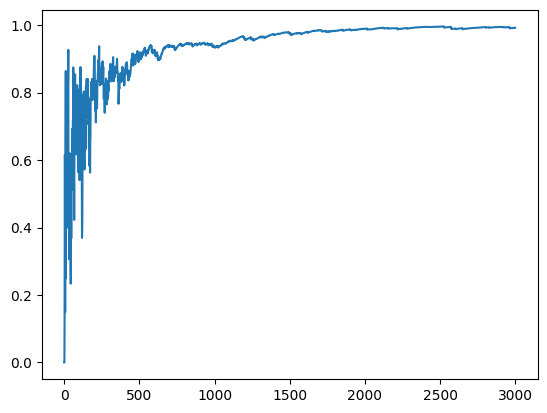

In [19]:
plt.plot(Q_track[:, 6, 1])

In [21]:
V_t

array([0.        , 0.46703682, 0.79947859, 0.9139864 , 0.96611605,
       0.98628231, 0.99193206, 0.9970668 , 0.        ])